# Data Augmentation using goemotions

## Setup

In [48]:
!export LC_ALL=C

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
np.set_printoptions(precision = 3, suppress = True)

Import `matplotlib` and create a helper function to plot graphs:

In [49]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[66044, 28981]


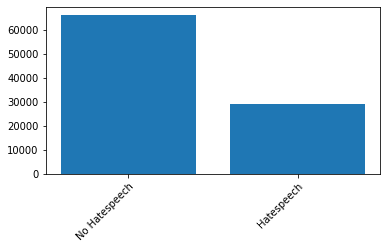

<Figure size 1152x432 with 0 Axes>

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_emotions(split='train'):
    dataset, info = tfds.load('goemotions', with_info = True, split = split)
    emotions = tfds.as_dataframe(ds = dataset)
    emotions = emotions.rename(columns = {'comment_text': 'text'})
    # Remove all lables
    rem = [
        'admiration',
        'amusement',
        'anger',
        'annoyance',
        'approval',
        'caring',
        'confusion',
        'curiosity',
        'desire',
        'disappointment',
        'disapproval',
        'disgust',
        'embarrassment',
        'excitement',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'nervousness',
        'neutral',
        'optimism',
        'pride',
        'realization',
        'relief',
        'remorse',
        'sadness',
        'surprise',
    ]

    emotions = emotions[emotions.columns.drop(rem)]
    # Add label that it isn't hatespeech
    emotions['is_hatespeech'] = 0
    return emotions


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("datasets/3_preprocessed.csv")
    df_6 = pd.read_csv("datasets/6_preprocessed.csv")

    df = df_1.append(df_3)
    df = df.append(df_6)

    train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True,
                                         stratify = df["is_hatespeech"])

    emo_df = pd.read_csv('./datasets/goemotions.csv', encoding = 'utf-8')

    emo_1, emo_2 = train_test_split(emo_df, test_size = 0.2, random_state = 42, shuffle = True)

    train_df = train_df.append(emo_1)
    test_df = test_df.append(emo_2)
    # emo_df = load_emotions()
    # emo_df = emo_df.append(load_emotions('test'))
    # emo_df = emo_df.append(load_emotions('validation'))


    return train_df, test_df


def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation = 45,
               rotation_mode = "anchor",
               ha = "right")

    plt.subplots_adjust(bottom = 0.3)
    plt.figure(figsize = (16, 6))
    plt.show()


train_df, test_df = load_data_arrays()

plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [51]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = tf.keras.utils.to_categorical(train_df['is_hatespeech'].values, num_classes = 2)
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype = str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = tf.keras.utils.to_categorical(test_df['is_hatespeech'].values, num_classes = 2)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype = str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [52]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [53]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, 42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create the text encoder

In [55]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Create the model

In [59]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

print(model.summary())

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.001),
              metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

## Train the model

In [60]:
history = model.fit(train_dataset, epochs = 5,
                    validation_data = test_dataset,
                    validation_steps = 10)

Epoch 1/5
1188/1188 [==============================] - 36s 27ms/step - loss: 0.1353 - accuracy: 0.9368 - val_loss: 6.1914 - val_accuracy: 0.4766
Epoch 2/5
1188/1188 [==============================] - 35s 29ms/step - loss: 0.1221 - accuracy: 0.9481 - val_loss: 3.9654 - val_accuracy: 0.4500
Epoch 3/5
1188/1188 [==============================] - 42s 35ms/step - loss: 0.1165 - accuracy: 0.9496 - val_loss: 2.9036 - val_accuracy: 0.5031
Epoch 4/5
1188/1188 [==============================] - 41s 35ms/step - loss: 0.1087 - accuracy: 0.9513 - val_loss: 2.5398 - val_accuracy: 0.3500
Epoch 5/5
1188/1188 [==============================] - 38s 32ms/step - loss: 0.1047 - accuracy: 0.9530 - val_loss: 1.7072 - val_accuracy: 0.6453


In [61]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

297/297 [==============================] - 4s 15ms/step - loss: 0.7373 - accuracy: 0.8386
Test Loss: 0.7372637391090393
Test Accuracy: 0.8385772705078125


(0.0, 6.495753978192806)

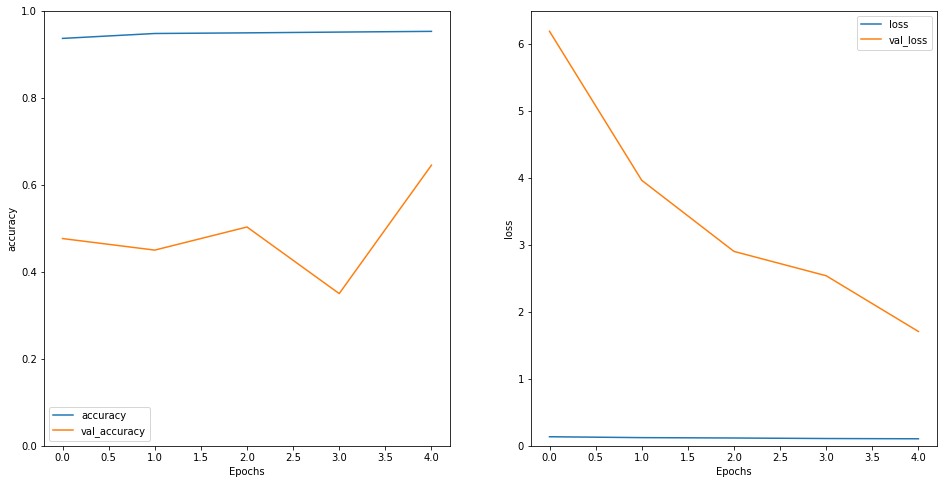

In [62]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)